In [2]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
import networkx as nx
import copy
import time

In [45]:
qubit_number = 4
qubits = range(qubit_number)

In [46]:
G=nx.cycle_graph(qubit_number)

In [47]:
for node in range(qubit_number):
    G.add_node(node)
    
G.nodes()

NodeView((0, 1, 2, 3))

In [48]:
for node in range(qubit_number):
    if node<qubit_number-1: 
        G.add_edge(node,node+1)
len(G.edges)

4

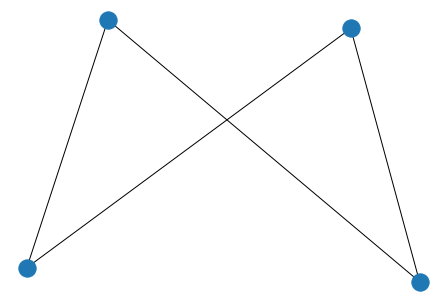

In [49]:
nx.draw(G) # because of periodic boundary condition

In [50]:
def H_matrix(graph,delta,no_of_qubits):
    # edge_weights= $\theta_1$ parameters for interaction terms
    # node_weights= $\theta_2$ parameters for single qubit terms
    
    full_matrix=np.zeros((2**no_of_qubits,2**no_of_qubits))
    
    # creating the two qubit interation terms:
    for i,edge in enumerate(graph.edges):
        
        zz_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only ZZ interaction 
                zz_int=np.kron(zz_int,qml.PauliZ.matrix)
                
            else:
                zz_int=np.kron(zz_int,np.identity(2))
                
        full_matrix+=delta*zz_int
        
        
    for i,edge in enumerate(graph.edges):
        
        xx_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only XX interaction 
                xx_int=np.kron(xx_int,qml.PauliX.matrix)
                
            else:
                xx_int=np.kron(xx_int,np.identity(2))
                
        full_matrix+=xx_int
        
       
    for i,edge in enumerate(graph.edges):
        
        yy_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only YY interaction 
                yy_int=np.kron(yy_int,qml.PauliY.matrix)
                
            else:
                yy_int=np.kron(yy_int,np.identity(2))
                
        full_matrix = full_matrix + yy_int
    
    return full_matrix

In [51]:
Ham=H_matrix(G,1,qubit_number)

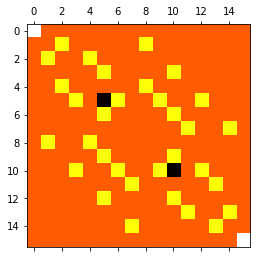

In [52]:
plt.matshow(np.real(Ham), cmap="hot")
plt.show()

In [53]:
min_energy=(np.real_if_close(min(np.linalg.eig(Ham)[0])))

In [54]:
print(f"Minimum eigen energy:{min_energy}")

Minimum eigen energy:-8.000000000000004


In [55]:
dev = qml.device("lightning.qubit", wires= qubit_number) 

In [56]:
wires=list(range(qubit_number)) # will be used below
print("length of wires",len(wires))
for i in wires:
    print("wire->",i)
print("length of edges",len(G.edges))

length of wires 4
wire-> 0
wire-> 1
wire-> 2
wire-> 3
length of edges 4


In [57]:
def HVA_layer(Jij_params):
    
    
    for i, edge in enumerate(G.edges):
        qml.MultiRZ(Jij_params[i*3]*(-1), wires=(edge[0], edge[1]))
        qml.IsingXX(Jij_params[i*3+1]*(-1), wires=(edge[0], edge[1]))
        qml.IsingYY(Jij_params[i*3+2]*(-1), wires=(edge[0], edge[1]))

In [60]:
coeffs_arr = np.concatenate([np.ones(qubit_number*2),np.ones(qubit_number)])

In [61]:
H=[]
obs=[]

for i in range(qubit_number):
    if i<qubit_number-1:
        obs.append(qml.PauliZ(i)@qml.PauliZ(i+1))
    else:
        obs.append(qml.PauliZ(i)@qml.PauliZ(0))

for i in range(qubit_number):
    if i<qubit_number-1:
        obs.append(qml.PauliX(i)@qml.PauliX(i+1))
    else:
        obs.append(qml.PauliX(i)@qml.PauliX(0))    
    
for i in range(qubit_number):
    if i<qubit_number-1:
        obs.append(qml.PauliY(i)@qml.PauliY(i+1))
    else:
        obs.append(qml.PauliY(i)@qml.PauliY(0)) 
        
H.append(qml.Hamiltonian(coeffs_arr, obs))
print((H)[0])
print(len(H))

  (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
+ (1.0) [Z3 Z0]
+ (1.0) [X0 X1]
+ (1.0) [X1 X2]
+ (1.0) [X2 X3]
+ (1.0) [X3 X0]
+ (1.0) [Y0 Y1]
+ (1.0) [Y1 Y2]
+ (1.0) [Y2 Y3]
+ (1.0) [Y3 Y0]
1


In [62]:
depth=1 #int(qubit_number/2)

In [63]:
params=np.random.rand(len(G.edges)*3*depth)
len(params)

12

In [68]:
#@qml.qnode(dev)
def full_HVA_ansatz(params, **kwargs):
    [qml.PauliX(wires=i) for i in range(qubit_number)]
    [qml.Hadamard(wires=2*i) for i in range(int(qubit_number/2))]
    [qml.CNOT(wires=[2*i,2*i+1]) for i in range(int(qubit_number/2))]
    for i in range(depth):
        HVA_layer(params[int(len(params)/depth)*i:int(len(params)/depth)*(i+1)])
    
#    return qml.state()  

In [69]:
start_time = time.time()    

cost_fn=qml.ExpvalCost(full_HVA_ansatz,H[0],dev)
    
end_time = time.time()
print('Time taken: ', (end_time-start_time)/60, ' mins.')

Time taken:  4.9897034962972005e-05  mins.


In [70]:
start_time = time.time()    
cost_fn(params)
end_time = time.time()
print('Time taken: ', (end_time-start_time)/60, ' mins.')

Time taken:  0.0017579158147176107  mins.


In [75]:
par_arr=[]
costarr=[]
opt_val_arr=[]

In [76]:
start_time = time.time()    

optimizer = qml.AdamOptimizer(stepsize=0.1)
#params=np.random.rand(len(G.edges))*0.1

for j in range(0, 100+1):
    params, cost = optimizer.step_and_cost(cost_fn, params)

# Prints the value of the cost function
    if j!=0 and j % 10 == 0:
        print(f"Cost at Step {j}: {cost}")

        costarr.append(cost)
        par_arr.append(params)
opt_val_arr.append(cost)

end_time = time.time()
print('Time taken: ', (end_time-start_time)/60, ' mins.')

Cost at Step 10: -7.936627946390688
Cost at Step 20: -7.977215593604184
Cost at Step 30: -7.990946898638981
Cost at Step 40: -7.996808617874053
Cost at Step 50: -7.998660238870704
Cost at Step 60: -7.999613551522336
Cost at Step 70: -7.999930878953451
Cost at Step 80: -7.999953949172532
Cost at Step 90: -7.999980204931132
Cost at Step 100: -7.999998958906115
Time taken:  2.2031587918599445  mins.


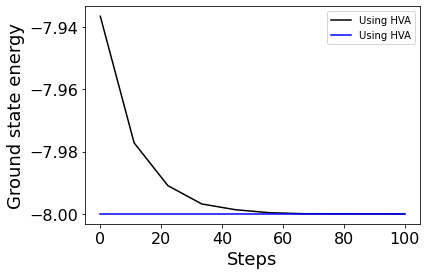

In [82]:
x=np.linspace(0,100,10)
n=np.ones(len(x))*min_energy
plt.plot(x,costarr,"black",label="Using HVA")
plt.plot(x,n,"blue",label="Using HVA")
plt.ylabel("Ground state energy", fontsize=18)
plt.xlabel("Steps", fontsize=18)
plt.tick_params(axis="both", colors='black',which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", colors='black', which="minor", labelsize=16)
#plt.ylim(-14, -6)
plt.legend()
plt.show()